In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from geopandas import GeoDataFrame
from numpy.random import RandomState, uniform
import numpy as np
import string
from sodapy import Socrata
import seaborn as sns
import networkx as nx
from networkx.algorithms import community
import community.community_louvain as community
from datetime import datetime
from pytz import timezone
import statsmodels.api as sm
%matplotlib inline

# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.cityofchicago.org", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.cityofchicago.org,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("m6dm-c72p", limit=8000000)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

#Specify Columns to Use
usecols=['Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Fare',
 'Tip',
 'Additional Charges',
 'Trip Total',
 'Trips Pooled',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude']


#Read in data
results_df=pd.read_csv(r'C:\Users\brandin_hirsch\Downloads\Transportation_Network_Providers_-_Trips.csv',usecols=usecols,dtype={'Dropoff Census Tract':'object','Pickup Census Tract':'object'})

#Read in map of Chicago
chicago_map=gpd.read_file(r'C:\Users\brandin_hirsch\Desktop\chicago\geo_export_e91837ed-0772-4931-9304-2631f6936d17.shp')

In [72]:
results_df.head(1)

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,...,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,dropoff_census_tract,pickup_census_tract,dropoff_centroid_latitude,pickup_centroid_latitude,dropoff_centroid_longitude,pickup_centroid_longitude,trip_count
0,11/01/2018 08:45:00 AM,11/01/2018 09:30:00 AM,3140.0,38.5,NaN,17031980100,47.5,10,9.1,66.6,...,NaN,41.785999,-87.750934,17031980100,NaN,41.785999,NaN,-87.750934,NaN,1


In [75]:
#Facts
#There are 866 census tracts in Chicago

#External Sources of knowledge
#https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6
#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

#Drop trips entirely outside of Chicago
results_df=results_df.dropna(subset=['dropoff_census_tract','pickup_census_tract','dropoff_centroid_latitude','pickup_centroid_latitude'],how='any')


# results_df=results_df.dropna(subset=['dropoff_census_tract','pickup_census_tract'],how='all')

# results_df=results_df.dropna(subset=['dropoff_centroid_latitude','pickup_centroid_latitude'],how='all')

results_df['dropoff_census_tract']=results_df['Dropoff Census Tract']

results_df['pickup_census_tract']=results_df['Pickup Census Tract']

results_df['dropoff_centroid_latitude']=results_df['Dropoff Centroid Latitude']

results_df['pickup_centroid_latitude']=results_df['Pickup Centroid Latitude']

results_df['dropoff_centroid_longitude']=results_df['Dropoff Centroid Longitude']

results_df['pickup_centroid_longitude']=results_df['Pickup Centroid Longitude']

results_df['trip_count']=1

 
#Calculating Network Values

#Create network analysis df to make sure every census tract we plot has a lat/long
network_analysis_df=results_df.dropna(subset=['dropoff_census_tract','pickup_census_tract','dropoff_centroid_latitude','pickup_centroid_latitude'],how='any')

#Create new empty dataframe for network analysis values
df_network_values=pd.DataFrame()

#Take the columns for start and end location and trip count into the network weights dataframe
df_network_values['start_location']=network_analysis_df['pickup_census_tract']

df_network_values['end_location']=network_analysis_df['dropoff_census_tract']

df_network_values['trip_count']=1

df_network_values=df_network_values.groupby(['start_location','end_location'])['trip_count'].sum()

df_network_values=pd.DataFrame(df_network_values)

df_network_values.reset_index(inplace=True)




#Calculating Network Weights

#Calculate sum of pickups and sum of dropoffs at each location 
pickups_sum=df_network_values[['start_location','trip_count']]

dropoffs_sum=df_network_values[['end_location','trip_count']]

#Rename columns for easy joining
pickups_sum.columns=['census_tract','trip_count']
dropoffs_sum.columns=['census_tract','trip_count']

#Join columns to get total pickups and dropoffs in each location
df_network_weights=pd.concat([pickups_sum,dropoffs_sum])

df_network_weights=pd.DataFrame(df_network_weights.groupby('census_tract')['trip_count'].sum())

df_network_weights.reset_index(inplace=True)

df_network_weights.sort_values(by='trip_count',ascending=False,inplace=True)

df_network_weights.head()

len(df_network_weights.census_tract.unique())

802

In [36]:
network_analysis_df.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,...,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,dropoff_census_tract,pickup_census_tract,dropoff_centroid_latitude,pickup_centroid_latitude,dropoff_centroid_longitude,pickup_centroid_longitude,trip_count
552,11/01/2018 11:45:00 AM,11/01/2018 12:00:00 PM,748.0,1.5,17031320400,17031081600,7.5,0,2.5,10.0,...,-87.621972,41.892073,-87.628874,17031081600,17031320400,41.892073,41.877406,-87.628874,-87.621972,1
553,11/01/2018 07:15:00 PM,11/01/2018 07:30:00 PM,758.0,3.7,17031081403,17031063200,7.5,0,2.5,10.0,...,-87.618868,41.938391,-87.638575,17031063200,17031081403,41.938391,41.890922,-87.638575,-87.618868,1
1036,12/14/2018 05:15:00 AM,12/14/2018 05:15:00 AM,432.0,1.3,17031839100,17031081500,7.5,0,0.0,7.5,...,-87.632746,41.892508,-87.626215,17031081500,17031839100,41.892508,41.880994,-87.626215,-87.632746,1
1037,12/20/2018 12:15:00 PM,12/20/2018 12:30:00 PM,851.0,2.5,17031320100,17031330100,7.5,1,2.5,11.0,...,-87.620993,41.859350,-87.617358,17031330100,17031320100,41.859350,41.884987,-87.617358,-87.620993,1
1038,11/10/2018 10:45:00 AM,11/10/2018 10:45:00 AM,314.0,1.2,17031062800,17031071000,5.0,0,2.5,7.5,...,-87.661265,41.921701,-87.655912,17031071000,17031062800,41.921701,41.936159,-87.655912,-87.661265,1


In [54]:
#Create list of census locations with latitude and longitude as locations to plot the network map

pickup_census=network_analysis_df[['pickup_census_tract','pickup_centroid_latitude','pickup_centroid_longitude']]
dropoff_census=network_analysis_df[['dropoff_census_tract','dropoff_centroid_latitude','dropoff_centroid_longitude']]

#Rename columns for easy joining
columns=['census_tract','Lat','Long']

pickup_census.columns=columns
dropoff_census.columns=columns

pos_data=pd.concat([pickup_census,dropoff_census])

pos_data.Long=pos_data.Long.astype(float)
pos_data.Lat=pos_data.Lat.astype(float)

mx, my = pos_data['Long'].values, pos_data['Lat'].values
pos = {}
for count, elem in enumerate (pos_data['census_tract']):
     pos[elem] = (mx[count], my[count])

C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


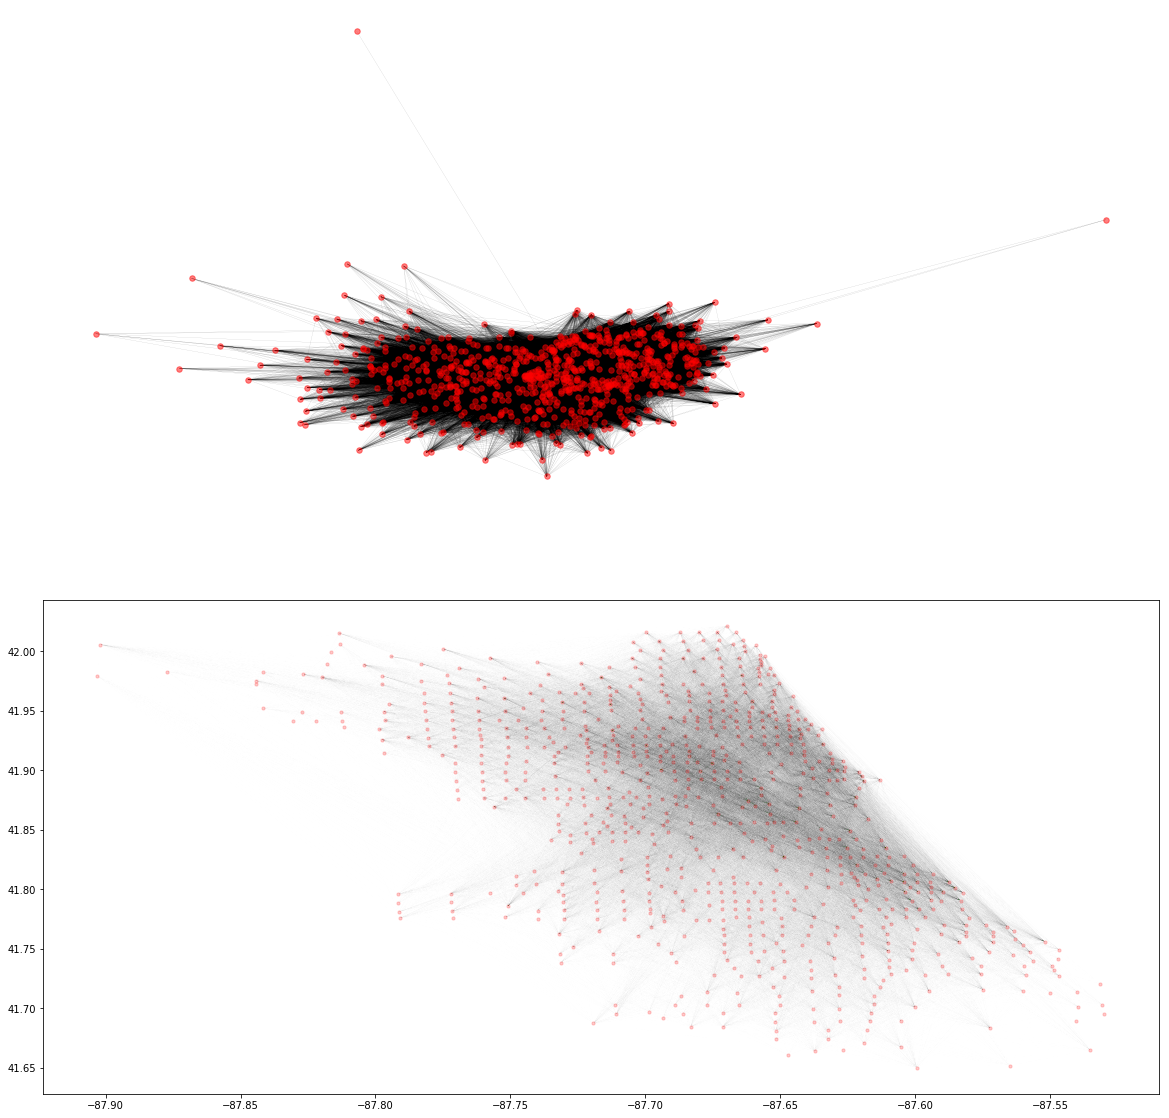

In [55]:
#Create non-directional network analysis
data_nwk =nx.Graph()
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (20,20))

G = nx.convert_matrix.from_pandas_edgelist(df_network_values, source='start_location', target='end_location',edge_attr='trip_count',create_using=data_nwk)


#Plot Analysis 

#Draw non directional graph
nx.draw(G, arrowsize=1,with_labels=False,node_size=30,alpha=.5,width=.1,ax=ax1)

#Draw graph in shape of Chicago
nx.draw_networkx_nodes(G, pos = pos, node_list = G.nodes(),node_color = 'r', alpha = 0.2, node_size = 10,ax=ax2)

nx.draw_networkx_edges(G, pos = pos, edge_color='g', alpha=.12, arrows = False,width=.015,ax=ax2)

plt.show()

In [56]:
#Use weights for node size to visually represent traffic volume 

#Create dataframe of the nodes from the network
node_list=pd.DataFrame(list(G.nodes))

node_list.columns=['census_tract']

node_weights=pd.merge(node_list,df_network_weights,how='left',on='census_tract')

node_weights['weight']=node_weights.trip_count/sum(node_weights.trip_count)*40000

node_weights=list(node_weights.weight)

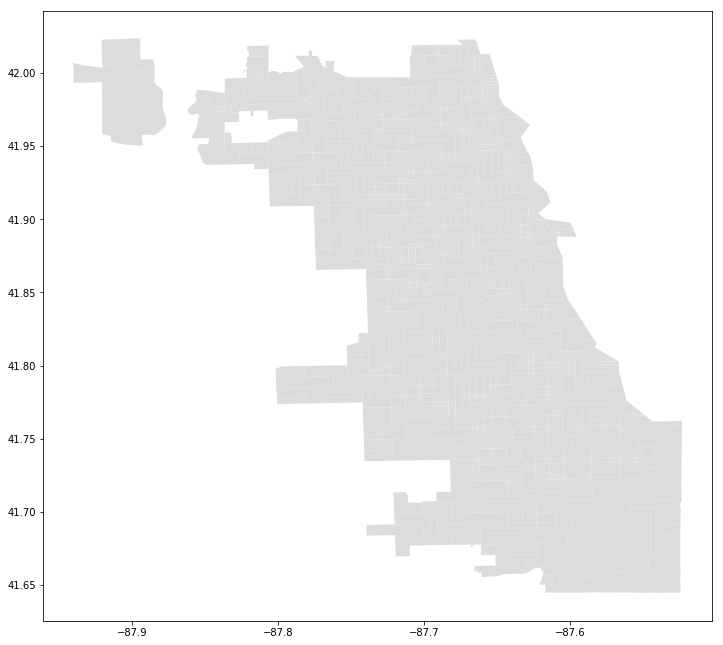

In [13]:
#Plot Map of Chicago

fig,ax=plt.subplots(figsize=(12,12))

chicago_map.plot(ax=ax,color='gainsboro')

C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


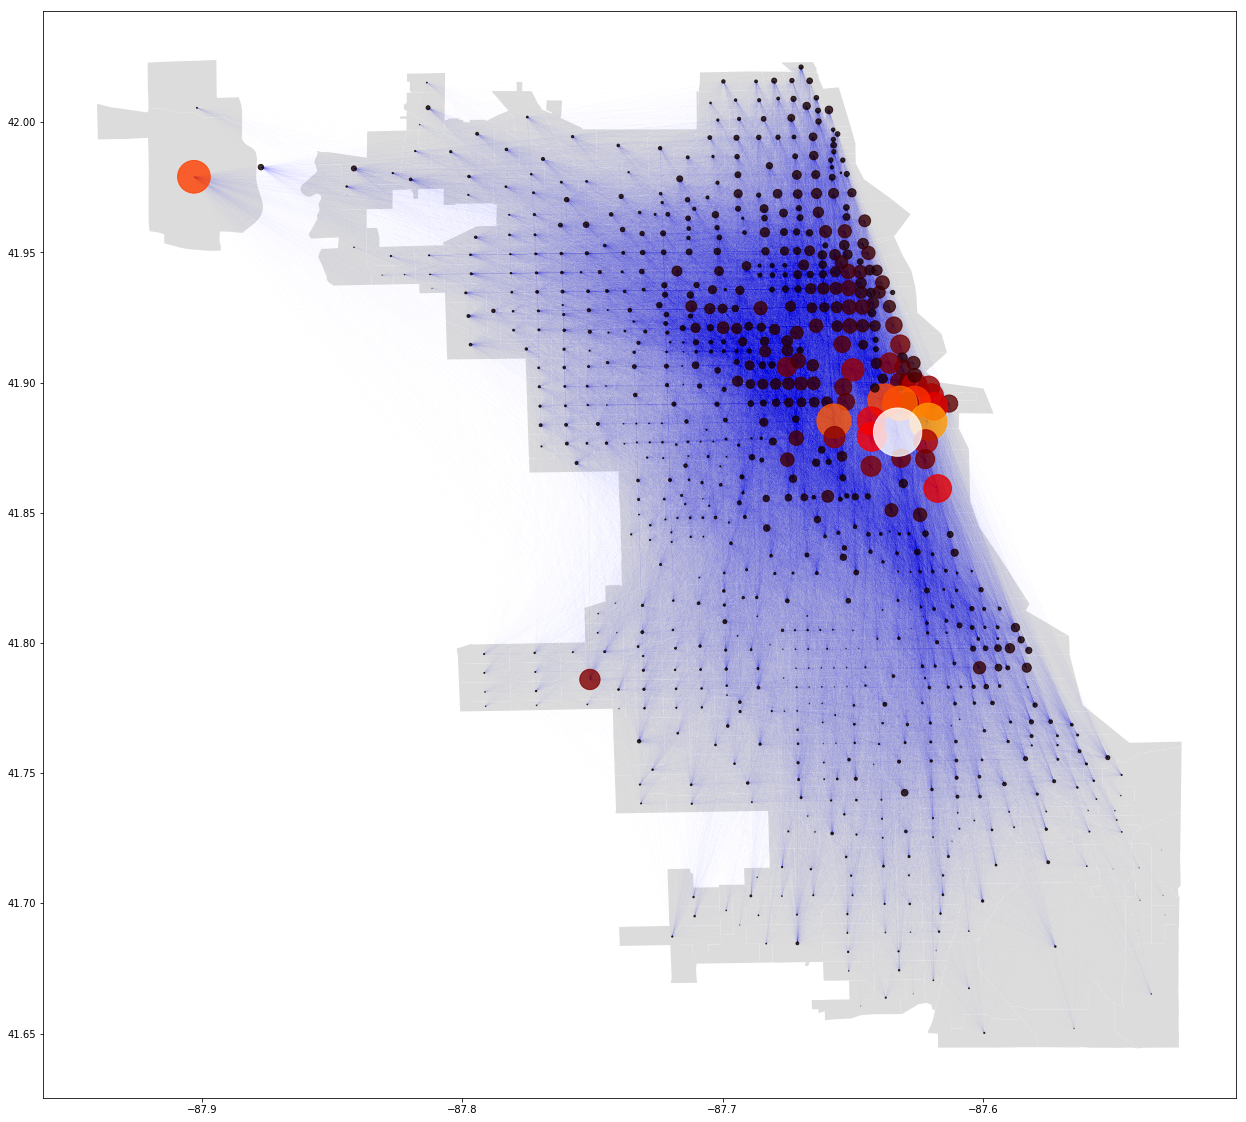

In [14]:
#Draw network on map of chicago with weights
fig,ax=plt.subplots(figsize=(25,20))
chicago_map.plot(ax=ax,color='gainsboro')
nx.draw_networkx_nodes(G, pos = pos, node_list = G.nodes(),node_color = node_weights, alpha = 0.8, node_size = node_weights,ax=ax,cmap='hot')
nx.draw_networkx_edges(G, pos = pos, edge_color='blue', alpha=.12, arrows = False,width=.018,ax=ax)

In [61]:
#Louvain Modularity Method for discovering underlying communities
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


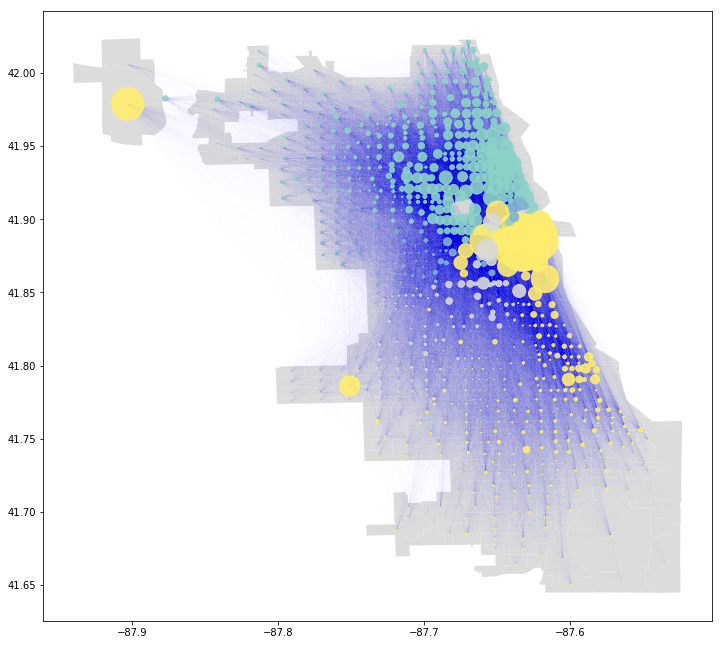

In [103]:
%matplotlib inline
fig,ax=plt.subplots(figsize=(12,12))

chicago_map.plot(ax=ax,color='gainsboro')


nx.draw_networkx_nodes(G, pos = pos, node_list = G.nodes(),node_color = values, alpha = .9, node_size = node_weights,ax=ax,cmap='Set3')
nx.draw_networkx_edges(G, pos = pos, edge_color='blue', alpha=.07, arrows = False,width=.028,ax=ax)

In [63]:
#Create dataframe of nodes and communities

#Create list of nodes
nodes=list(G.nodes())

#Create communities dataframe using list of nodes and list of community values from Louvain Modularity Method
df_communities=pd.DataFrame({'community_name':values,'census_tract':nodes})

df_communities.community_name=df_communities.community_name.astype(str)

df_communities.community_name.unique()

array(['0', '1', '2', '3'], dtype=object)

In [82]:
def dropoff_or_pickup(dataframe,labels,groupby_field,aggregate_field):
    """
    Helper function to split dataset into pickups and dropoffs, and aggregate by chosen field, usually census tract and timestamp
    """
    
    dataframe_cleaned=dataframe.drop(labels=labels,axis=1)
    dataframe_cleaned=pd.DataFrame(dataframe_cleaned.groupby(groupby_field)[aggregate_field].count())
    dataframe_cleaned.reset_index(inplace=True)
    
    return dataframe_cleaned


#Create dataframe with no missing pickups
all_pickups_df=results_df.dropna(subset=['pickup_census_tract'],how='any')


#Create dataframe with no missing dropoffs
all_dropoffs_df=results_df.dropna(subset=['dropoff_census_tract'],how='any')


#Create two dataframes for pickups and dropoffs
pickup_fields= ['pickup_centroid_longitude','pickup_centroid_latitude','pickup_census_tract','Trip Start Timestamp']
dropoff_fields= ['dropoff_centroid_longitude','dropoff_centroid_latitude','dropoff_census_tract','Trip End Timestamp']

#Pickup Dataframe
df_pickup=dropoff_or_pickup(all_pickups_df,dropoff_fields,['pickup_census_tract','Trip Start Timestamp'],'trip_count')

# #Dropoff Dataframe
# df_dropoff=dropoff_or_pickup(df_cleaned,pickup_fields,['dropoff_day'],'trip_id')


# df_pickup['Trip Start Timestamp']=pd.to_datetime(df_pickup['Trip Start Timestamp'],infer_datetime_format=True)

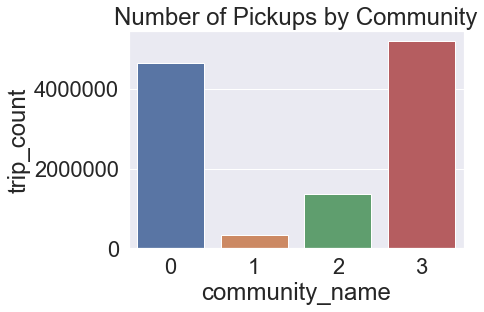

In [168]:
#Create dataframe of pickups by community
df_pickup_communities=df_pickup.merge(df_communities,how='left', left_on='pickup_census_tract',right_on='census_tract')



communities_pickup_graph_df=pd.DataFrame(df_pickup_communities.groupby('community_name')['trip_count'].sum())
communities_pickup_graph_df.reset_index(inplace=True)

plt.xlabel("Community Label")
plt.ylabel("Total Number of Trips")
plt.title("Number of Pickups by Community")
sns.barplot(x='community_name',y='trip_count',data=communities_pickup_graph_df) 

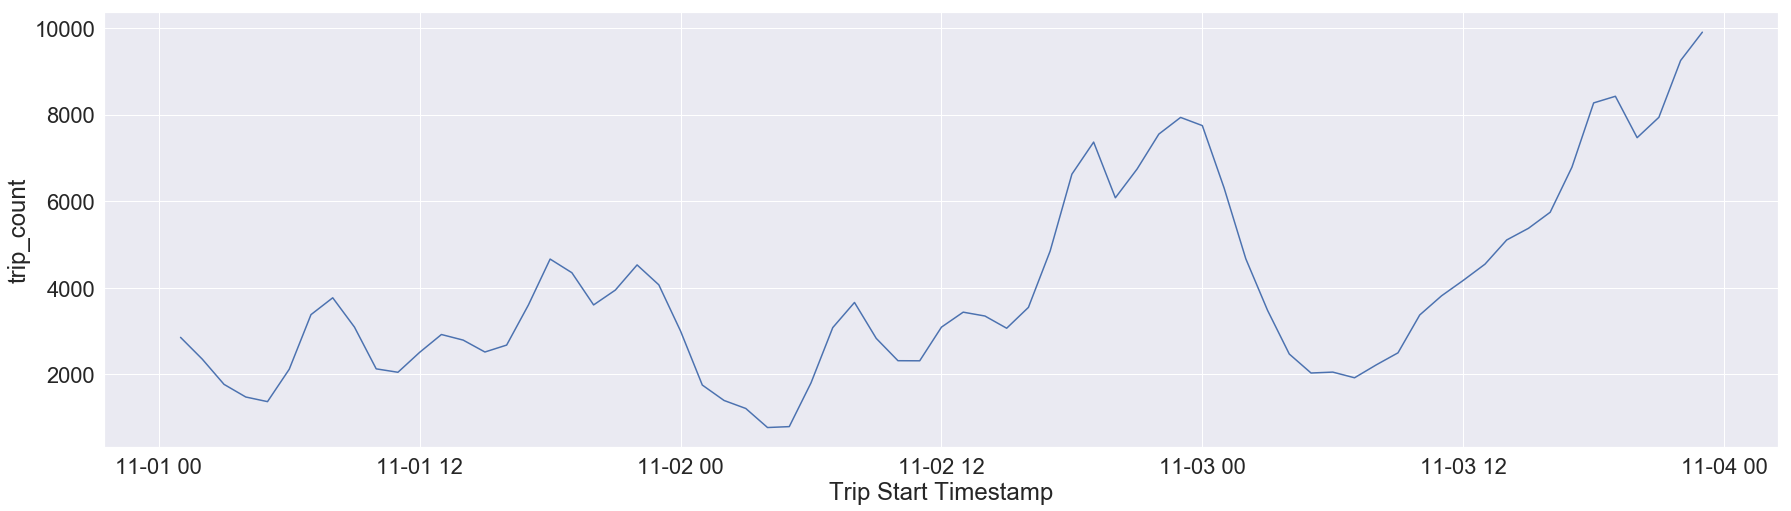

In [384]:
#Setup Seaborn Plot
sns.set(font_scale=2)
fig, ax = plt.subplots(1,1,figsize=(30,8))
# ax.xaxis.set_major_locator(plt.MaxNLocator(20))

#Group together the entire group dataframe by community name and trip start time
df_pickup_community_grouped=pd.DataFrame(df_pickup_communities.groupby(['community_name','Trip Start Timestamp'])['trip_count'].sum())
df_pickup_community_grouped.reset_index(inplace=True)

#Convert trip start time to date, take out the minutes,leave it as a pandas object for further group bys
df_pickup_community_grouped['Trip Start Timestamp']=pd.to_datetime(df_pickup_community_grouped['Trip Start Timestamp'],infer_datetime_format=True)

df_pickup_community_grouped.sort_values(by='Trip Start Timestamp',inplace=True)

df_pickup_community_grouped['Trip Start Timestamp']=df_pickup_community_grouped['Trip Start Timestamp'].dt.strftime('%Y-%m-%d %H')


#Select all the separate communities and their pickup data
df_pickup_community_0=df_pickup_community_grouped[df_pickup_community_grouped['community_name']=='0']

df_pickup_community_1=df_pickup_community_grouped[df_pickup_community_grouped['community_name']=='1']

df_pickup_community_2=df_pickup_community_grouped[df_pickup_community_grouped['community_name']=='2']

df_pickup_community_3=df_pickup_community_grouped[df_pickup_community_grouped['community_name']=='3']


#Group each dataframe by community and hour

#Community 0
df_pickup_community_0=pd.DataFrame(df_pickup_community_0.groupby(['community_name','Trip Start Timestamp'])['trip_count'].sum())

df_pickup_community_0.reset_index(inplace=True)

df_pickup_community_0['Trip Start Timestamp']=pd.to_datetime(df_pickup_community_0['Trip Start Timestamp'],infer_datetime_format=True)


#Community 1
df_pickup_community_1=pd.DataFrame(df_pickup_community_1.groupby(['community_name','Trip Start Timestamp'])['trip_count'].sum())

df_pickup_community_1.reset_index(inplace=True)

df_pickup_community_1['Trip Start Timestamp']=pd.to_datetime(df_pickup_community_1['Trip Start Timestamp'],infer_datetime_format=True)


#Community 2
df_pickup_community_2=pd.DataFrame(df_pickup_community_2.groupby(['community_name','Trip Start Timestamp'])['trip_count'].sum())

df_pickup_community_2.reset_index(inplace=True)

df_pickup_community_2['Trip Start Timestamp']=pd.to_datetime(df_pickup_community_2['Trip Start Timestamp'],infer_datetime_format=True)


#Community 3
df_pickup_community_3=pd.DataFrame(df_pickup_community_3.groupby(['community_name','Trip Start Timestamp'])['trip_count'].sum())

df_pickup_community_3.reset_index(inplace=True)

df_pickup_community_3['Trip Start Timestamp']=pd.to_datetime(df_pickup_community_0['Trip Start Timestamp'],infer_datetime_format=True)





#Plot a few days from community 0
mask=(df_pickup_community_0['Trip Start Timestamp']> '2018-11-01 00') & (df_pickup_community_0['Trip Start Timestamp']< '2018-11-04 00')

df_pickup_community2_0=df_pickup_community_0[mask]


sns.lineplot(x='Trip Start Timestamp',y='trip_count',data=df_pickup_community2_0)
      


In [385]:
df_pickup_community2_0.head()

,community_name,Trip Start Timestamp,trip_count
1,0,2018-11-01 01:00:00,2854
2,0,2018-11-01 02:00:00,2351
3,0,2018-11-01 03:00:00,1769
4,0,2018-11-01 04:00:00,1477
5,0,2018-11-01 05:00:00,1370


In [386]:
#Make the timestamp the index for each community
df_pickup_community_0.set_index('Trip Start Timestamp',inplace=True)

df_pickup_community_1.set_index('Trip Start Timestamp',inplace=True)

df_pickup_community_2.set_index('Trip Start Timestamp',inplace=True)

df_pickup_community_3.set_index('Trip Start Timestamp',inplace=True)

#Drop community name column
df_pickup_community_0.drop(labels='community_name',axis=1,inplace=True)

df_pickup_community_1.drop(labels='community_name',axis=1,inplace=True)

df_pickup_community_2.drop(labels='community_name',axis=1,inplace=True)

df_pickup_community_3.drop(labels='community_name',axis=1,inplace=True)


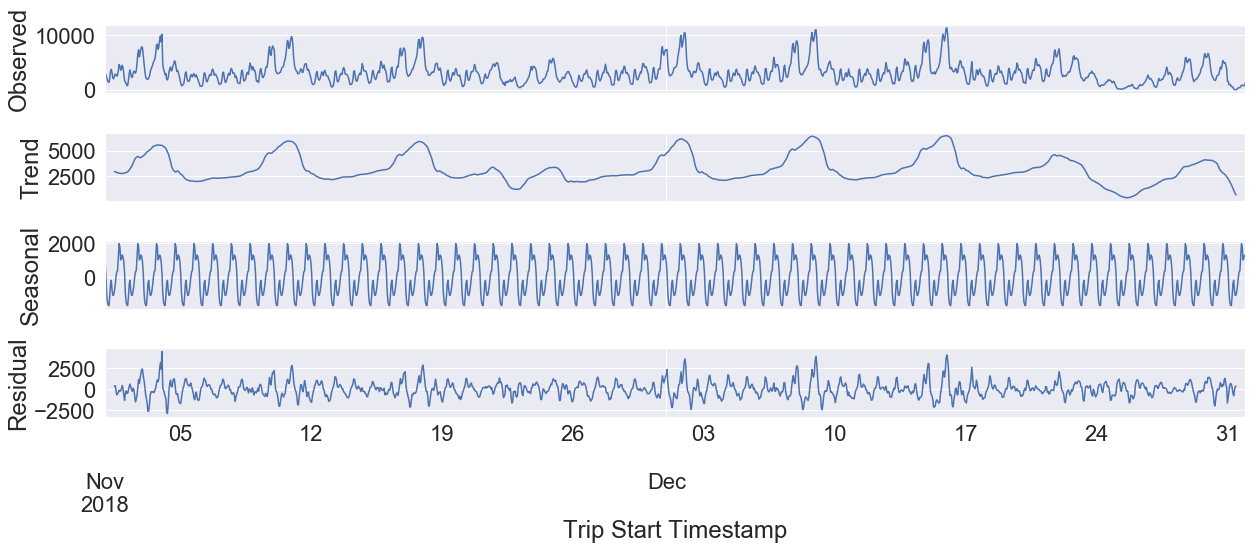

In [387]:
#Calculate trend and seasonalty using moving averages (stats model package)

#Show decomposition for community 0
community_0_decomposition = sm.tsa.seasonal_decompose(df_pickup_community_0, model='additive')
fig = decomposition.plot()
plt.show()

community_0_residual=community_0_decomposition.resid

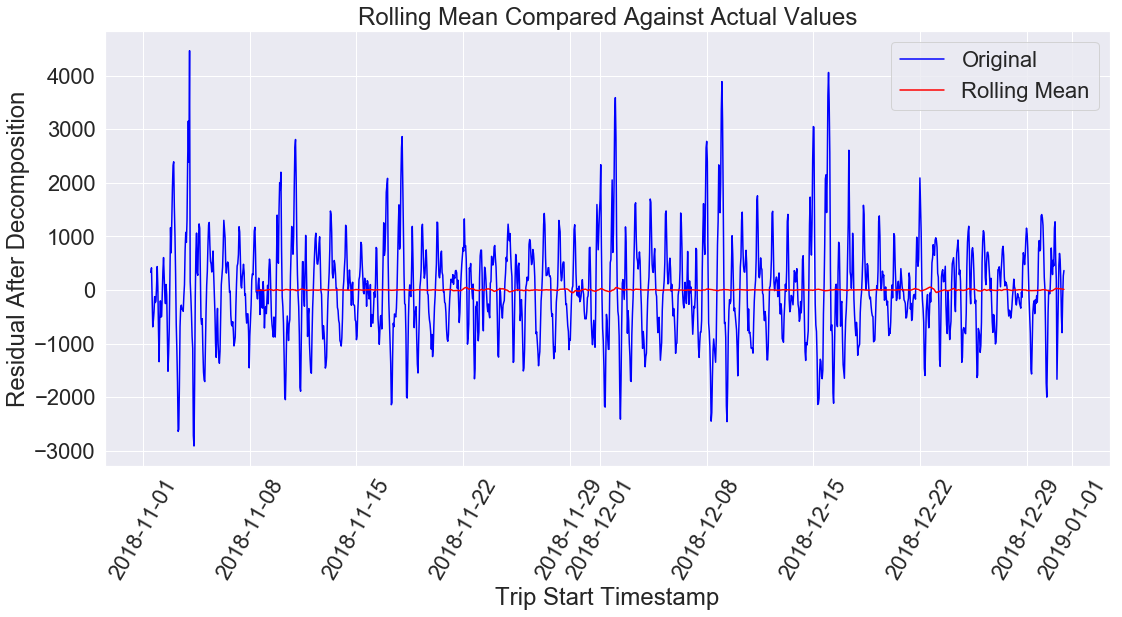

Results of Dickey-Fuller Test:
Test Statistic                -1.309218e+01
p-value                        1.779185e-24
#Lags Used                     2.400000e+01
Number of Observations Used    1.415000e+03
Critical Value (1%)           -3.434980e+00
Critical Value (5%)           -2.863585e+00
Critical Value (10%)          -2.567859e+00
dtype: float64


In [426]:
#Function taken from internet to easily plot residual vs moving average to visualize stationarity

def test_stationarity(timeseries):
    
    
    
    #Calculate rolling mean using the number as # of datapoints back to look, 168 is the number of hours in a week
    rolmean = timeseries.rolling(168).mean() 

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean Compared Against Actual Values')
    plt.xlabel("Trip Start Timestamp")
    plt.ylabel("Residual After Decomposition")
    plt.xticks(rotation=60)
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    timeseries=timeseries.dropna()
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(community_0_residual)

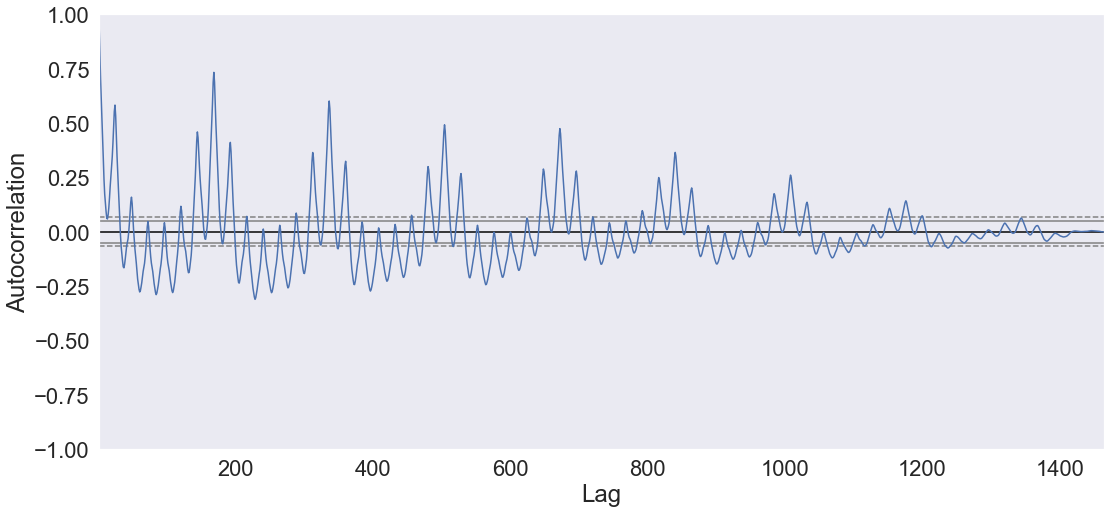

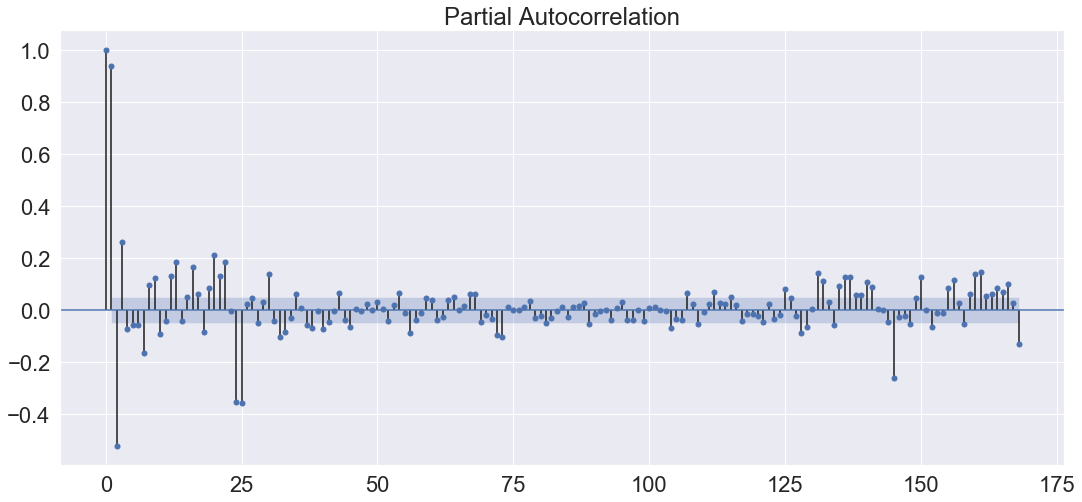

In [414]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
autocorrelation_plot(df_pickup_community_0)
plot_pacf(df_pickup_community_0, lags=168)
plt.show()

C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


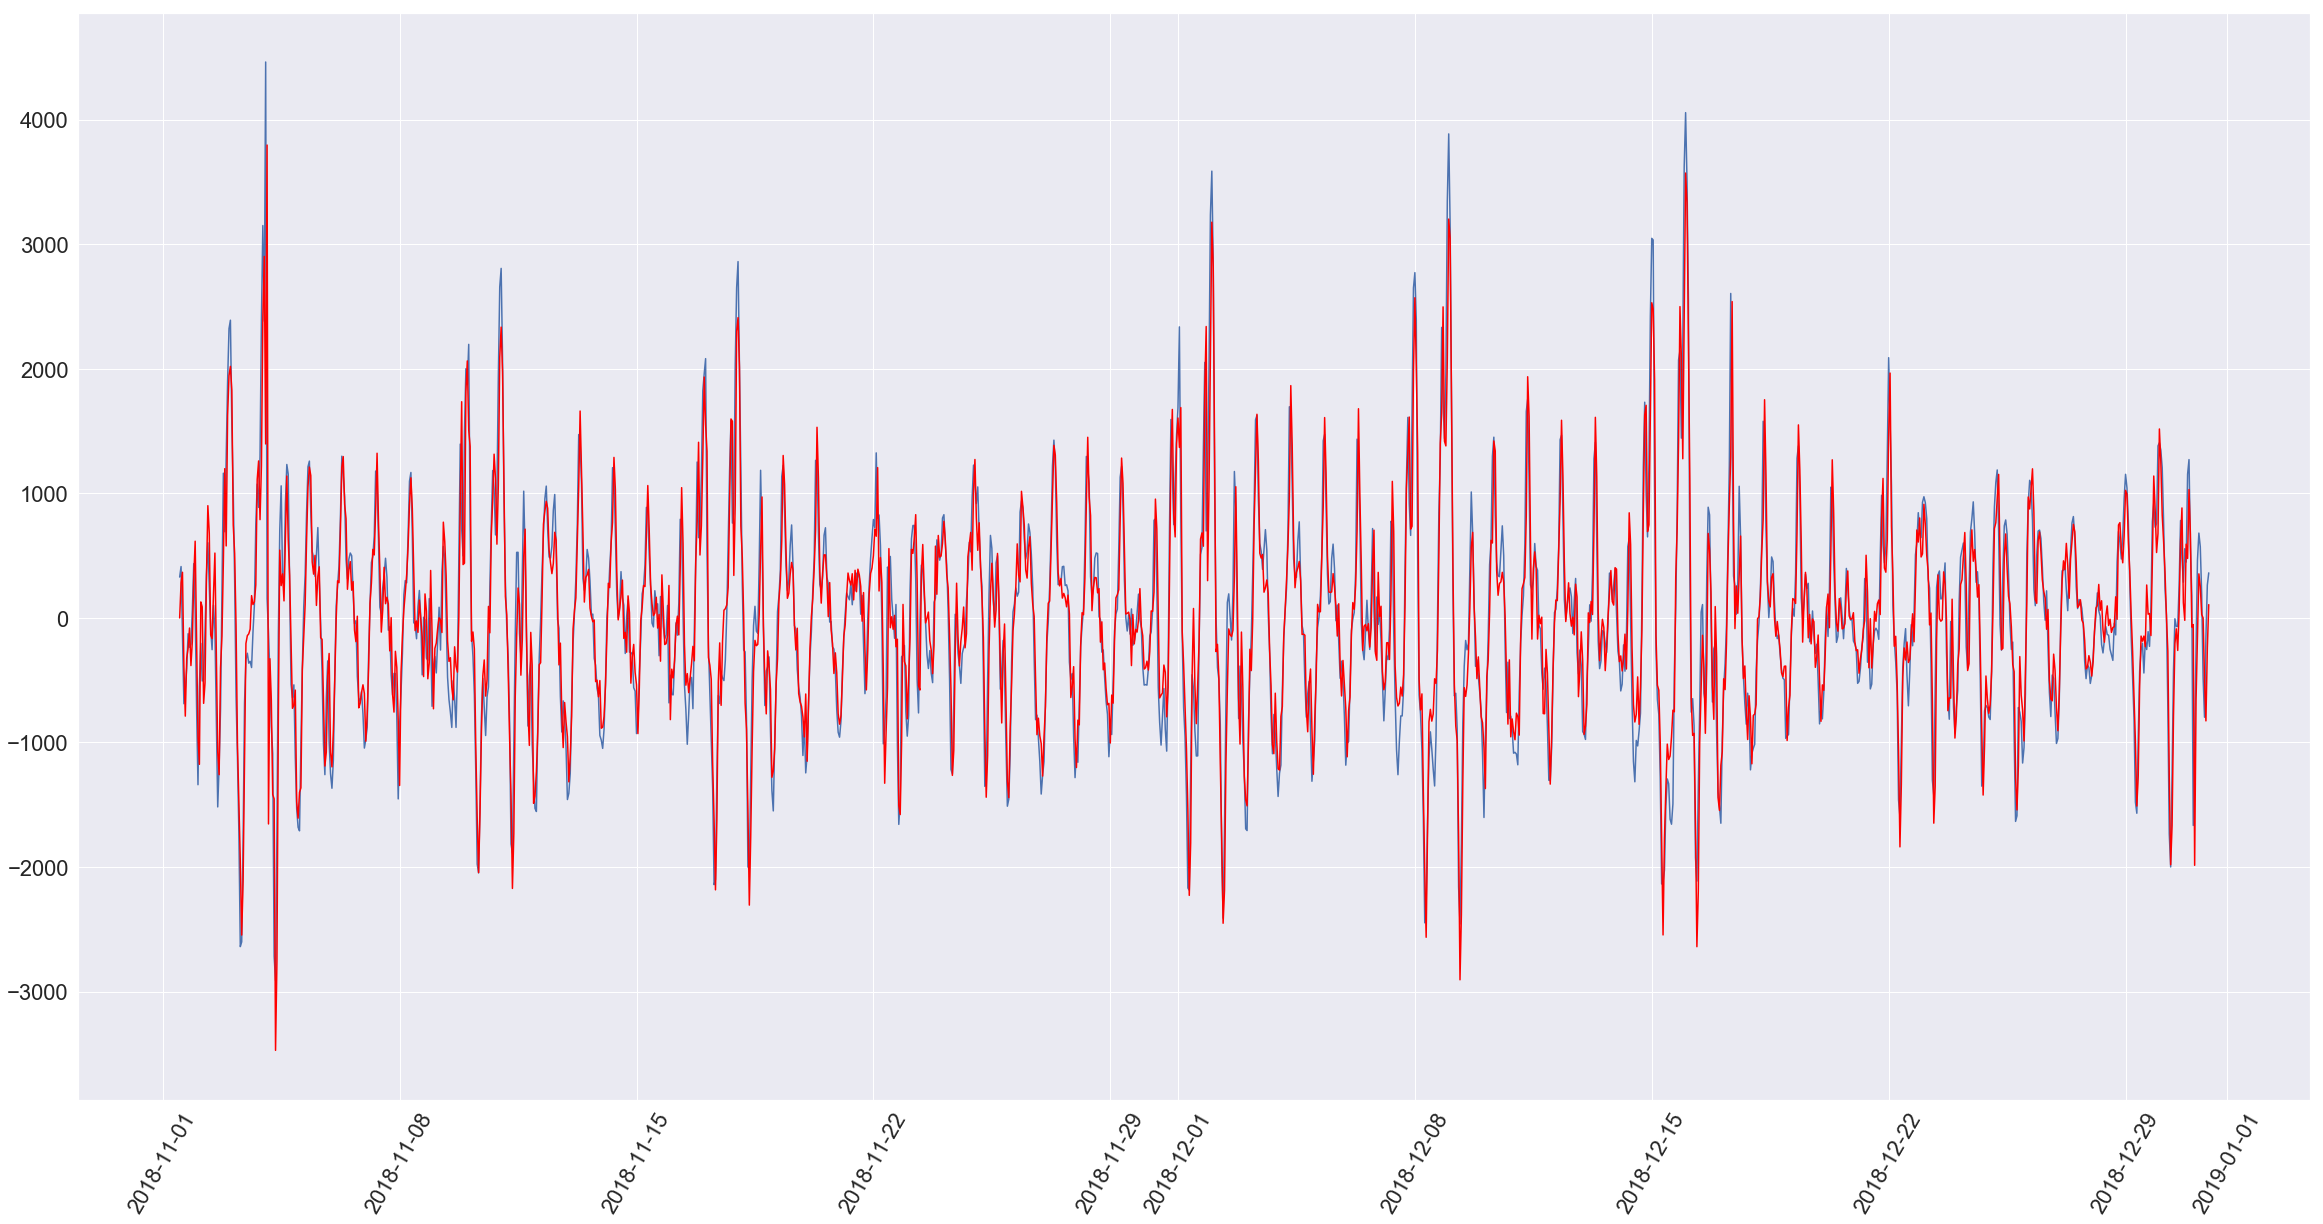

In [416]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(40,20)) 


model = ARIMA(community_0_residual.dropna(), order=(10,0,5))
result_AR = model.fit(disp=-1)
plt.plot(community_0_residual)
plt.plot(result_AR.fittedvalues, color='red')
plt.xticks(rotation=60)
plt.show()

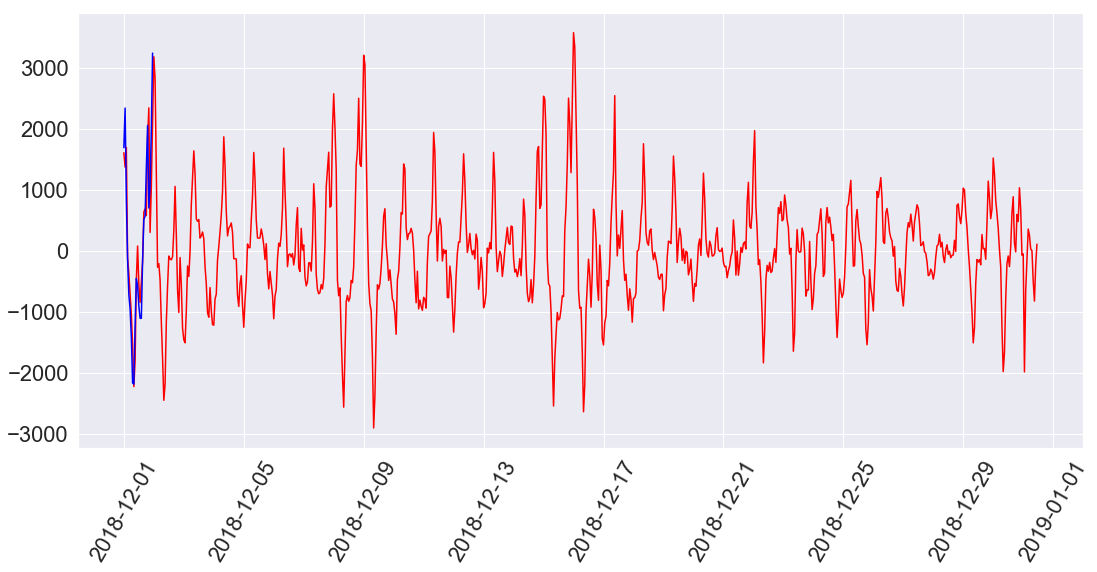

In [436]:
pred = result_AR.predict(start=pd.to_datetime('2018-12-01'), dynamic=False)
actuals=community_0_residual['2018-12-01']

plt.plot(pred, color='red')
plt.plot(actuals,color='blue')
plt.xticks(rotation=60)
plt.show()